# Implementing self-attention

## 1. A simple self-attention mechanism without trainable weights

What we're trying to start with here is by calculating the context vector $z^{(2)}$. See the figure for more context.
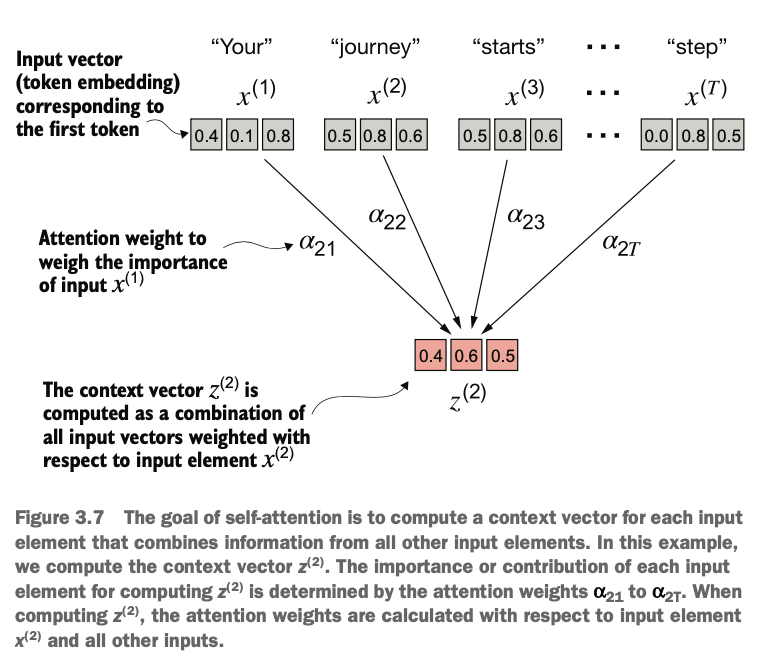

---

### Step 1: Compute the intermediate values `w` (attention scores)

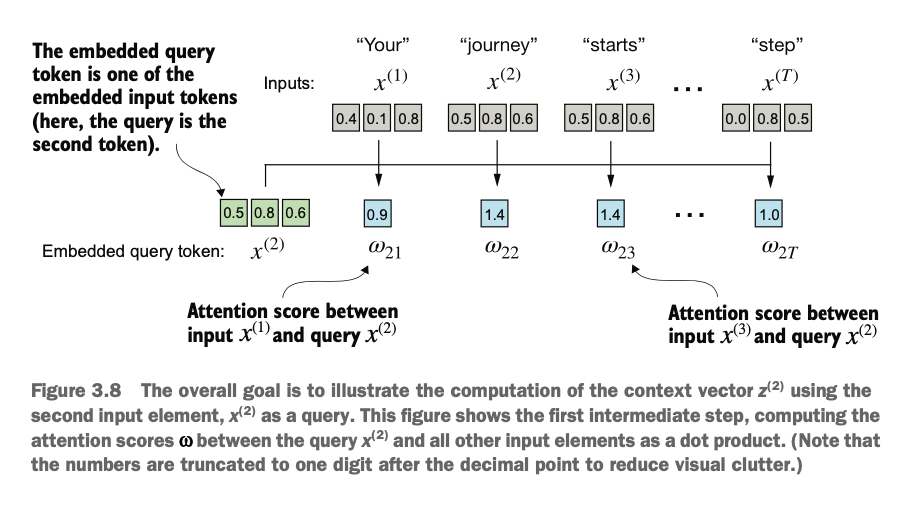

In [1]:
import torch

In [2]:
inputs = torch.tensor(
    [[0.43, 0.15, 0.89], # Your     (x^1)
     [0.55, 0.87, 0.66], # journey  (x^2)
     [0.57, 0.85, 0.64], # starts (x^3)
     [0.22, 0.58, 0.33], # with (x^4)
     [0.77, 0.25, 0.10], # one (x^5)
     [0.05, 0.80, 0.55]] # step (x^6)
)

inputs

tensor([[0.4300, 0.1500, 0.8900],
        [0.5500, 0.8700, 0.6600],
        [0.5700, 0.8500, 0.6400],
        [0.2200, 0.5800, 0.3300],
        [0.7700, 0.2500, 0.1000],
        [0.0500, 0.8000, 0.5500]])

For making it super clear, I'm breaking the figure 3.8 down into the absolute fundamentals in the 2 cells below to get the picture of what's exactly happening.

In [3]:
# second input token here is serving as the query, just like in figure 3.8
x_2_query = torch.tensor([0.55, 0.87, 0.66])

# each element from the input embedding sequence
x_1 = torch.tensor([0.43, 0.15, 0.89])
x_2 = torch.tensor([0.55, 0.87, 0.66])
x_3 = torch.tensor([0.57, 0.85, 0.64])
x_4 = torch.tensor([0.22, 0.58, 0.33])
x_5 = torch.tensor([0.77, 0.25, 0.10])
x_T = torch.tensor([0.05, 0.80, 0.55])

In [4]:
print(f'''Dot products here are the intermediate attention scores.
Figure 3.8 above gives us the same w_21, w_22, w_23, ...., w_2T.
Attention score w_21: {torch.dot(x_2_query, x_1)}
Attention score w_22: {torch.dot(x_2_query, x_2)}
Attention score w_23: {torch.dot(x_2_query, x_3)}
Attention score w_24: {torch.dot(x_2_query, x_4)}
Attention score w_25: {torch.dot(x_2_query, x_5)}
Attention score w_2T: {torch.dot(x_2_query, x_T)}
''')

Dot products here are the intermediate attention scores.
Figure 3.8 above gives us the same w_21, w_22, w_23, ...., w_2T.
Attention score w_21: 0.9544000625610352
Attention score w_22: 1.4950001239776611
Attention score w_23: 1.4754000902175903
Attention score w_24: 0.8434000015258789
Attention score w_25: 0.7070000171661377
Attention score w_2T: 1.0865000486373901



Doing the above in a less-redundant way:

In [5]:
query = inputs[1]

attn_scores_2 = torch.empty(inputs.shape[0])

for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query)

attn_scores_2

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])

same result as above.

_Beyond viewing the dot product operation as a mathematical tool that combines two vectors to yield a scalar value, the dot product is a measure of similarity because it quantifies how closely two vectors are aligned: a higher dot product indicates a greater degree of alignment or similarity between the vectors. In the context of self-attention mechanisms, the dot product determines the extent to which each element in a sequence focuses on, or “attends to,” any other element: the higher the dot product, the higher the similarity and attention score between two elements._

---

### Step 2: Normalize each of the attention scores computed

Basically this:
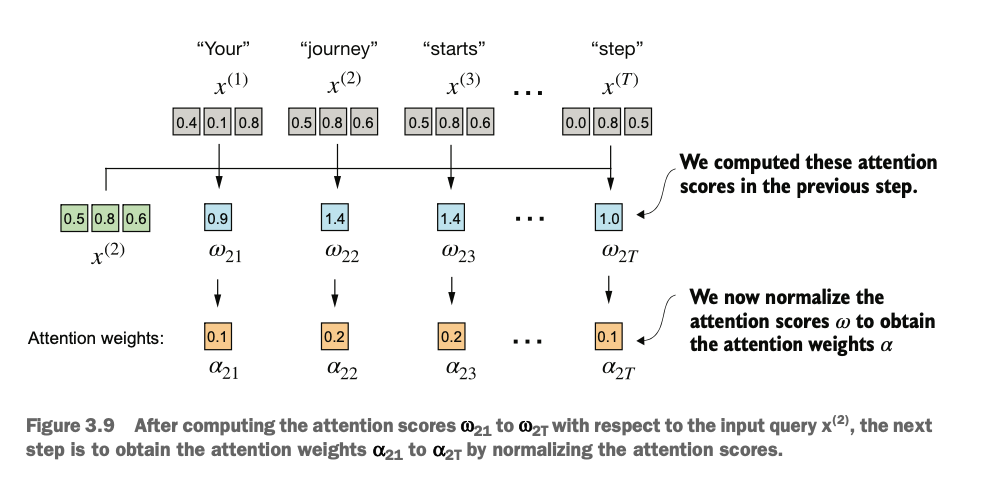

#### Normalizing with the most basic method ↓

In [6]:
attn_weights_2_sum_method = attn_scores_2 / attn_scores_2.sum()
print(f"Attention weights with the normal sum division method:\n{attn_weights_2_sum_method}")
print("\nSum: ", attn_weights_2_sum_method.sum())

Attention weights with the normal sum division method:
tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])

Sum:  tensor(1.0000)


#### Normalizing with the basic softmax implementation ↓

torch.exp Returns a new tensor with the exponential of the elements of the input tensor input.\
documentation: https://pytorch.org/docs/stable/generated/torch.exp.html

In [7]:
def softmax_naive(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)

attn_weights_2_naive = softmax_naive(attn_scores_2)

print(f"Attention weights with the basic softmax implementation:\n{attn_weights_2_naive}")
print("\nSum: ", attn_weights_2_naive.sum())

Attention weights with the basic softmax implementation:
tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])

Sum:  tensor(1.)


#### (Recommended) Normalizing with the PyTorch implementation of softmax ↓

In [8]:
attn_weights_2 = torch.softmax(attn_scores_2, dim=0)
print(f"Attention weights with torch implementation of softmax:\n{attn_weights_2}")
print("\nSum: ", attn_weights_2.sum())

Attention weights with torch implementation of softmax:
tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])

Sum:  tensor(1.)


### Step 3: Calculating the context vector $z^{(i)}$
> $z^{(2)}$ in my case

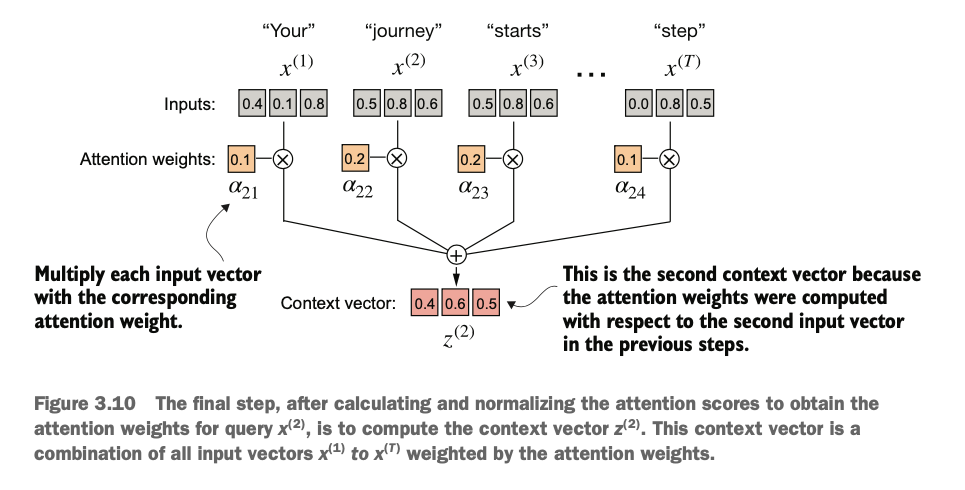


Context vector $z^{(2)}$ is calculated by multiplying the embedded input tokens, $x^{(i)}$, with the corresponding attention weights and then summing the resulting vectors. Thus, context vector $z^{(2)}$ is the weighted sum of all input vectors, obtained by multiplying each input vector by its corresponding attention weight. Implementation of this (as I can see in figure 3.10) below:

In [9]:
query = inputs[1]

context_vec_2 = torch.zeros(query.shape)
for i, x_i in enumerate(inputs):
    print("x_i: ", x_i)
    print("Attention weight: ", attn_weights_2[i])
    context_vec_2 += x_i * attn_weights_2[i]
    print("Context vec_2:", context_vec_2, "\n-------")

context_vec_2

x_i:  tensor([0.4300, 0.1500, 0.8900])
Attention weight:  tensor(0.1385)
Context vec_2: tensor([0.0596, 0.0208, 0.1233]) 
-------
x_i:  tensor([0.5500, 0.8700, 0.6600])
Attention weight:  tensor(0.2379)
Context vec_2: tensor([0.1904, 0.2277, 0.2803]) 
-------
x_i:  tensor([0.5700, 0.8500, 0.6400])
Attention weight:  tensor(0.2333)
Context vec_2: tensor([0.3234, 0.4260, 0.4296]) 
-------
x_i:  tensor([0.2200, 0.5800, 0.3300])
Attention weight:  tensor(0.1240)
Context vec_2: tensor([0.3507, 0.4979, 0.4705]) 
-------
x_i:  tensor([0.7700, 0.2500, 0.1000])
Attention weight:  tensor(0.1082)
Context vec_2: tensor([0.4340, 0.5250, 0.4813]) 
-------
x_i:  tensor([0.0500, 0.8000, 0.5500])
Attention weight:  tensor(0.1581)
Context vec_2: tensor([0.4419, 0.6515, 0.5683]) 
-------


tensor([0.4419, 0.6515, 0.5683])

---
---

## 2. Computing attention weights for all input tokens (and not just one)

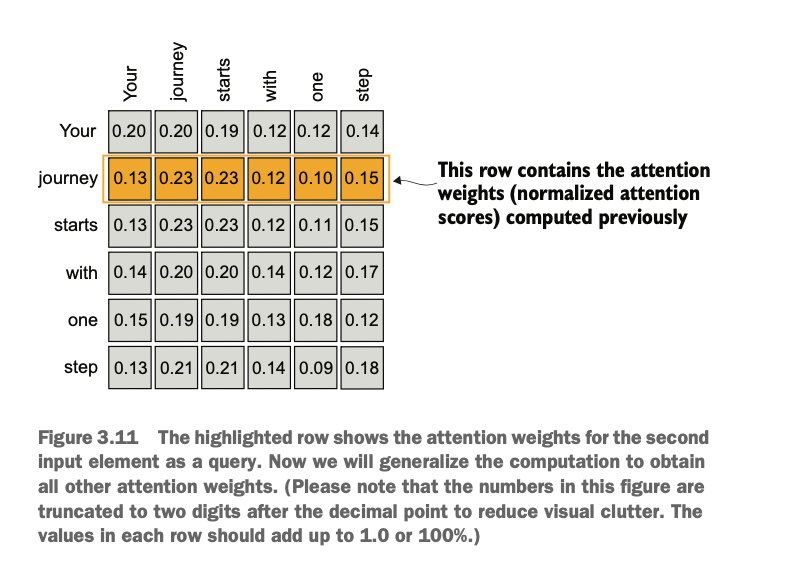

#### I can use the `for` loop to calculate attention scores... 

In [10]:
attn_scores = torch.empty(6,6)

inputs = torch.tensor(
    [[0.43, 0.15, 0.89], # Your     (x^1)
     [0.55, 0.87, 0.66], # journey  (x^2)
     [0.57, 0.85, 0.64], # starts (x^3)
     [0.22, 0.58, 0.33], # with (x^4)
     [0.77, 0.25, 0.10], # one (x^5)
     [0.05, 0.80, 0.55]] # step (x^6)
)

print(inputs)

print("\n==========================")

for i, x_i in enumerate(inputs):
    print(f"i: {i}")
    for j, x_j in enumerate(inputs):
        print("x_j:", x_j)
        attn_scores[i, j] = torch.dot(x_i, x_j)
        print("attn_scores[i,j]:", attn_scores)
    print("==================")
print("Attention scores:", attn_scores)

tensor([[0.4300, 0.1500, 0.8900],
        [0.5500, 0.8700, 0.6600],
        [0.5700, 0.8500, 0.6400],
        [0.2200, 0.5800, 0.3300],
        [0.7700, 0.2500, 0.1000],
        [0.0500, 0.8000, 0.5500]])

i: 0
x_j: tensor([0.4300, 0.1500, 0.8900])
attn_scores[i,j]: tensor([[0.9995, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
x_j: tensor([0.5500, 0.8700, 0.6600])
attn_scores[i,j]: tensor([[0.9995, 0.9544, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.000

#### but this `for` loop can often cause slowness. `matmul` is better here:

In [11]:
print(inputs, "\n===")
inputs_transpose = inputs.T
inputs_transpose

tensor([[0.4300, 0.1500, 0.8900],
        [0.5500, 0.8700, 0.6600],
        [0.5700, 0.8500, 0.6400],
        [0.2200, 0.5800, 0.3300],
        [0.7700, 0.2500, 0.1000],
        [0.0500, 0.8000, 0.5500]]) 
===


tensor([[0.4300, 0.5500, 0.5700, 0.2200, 0.7700, 0.0500],
        [0.1500, 0.8700, 0.8500, 0.5800, 0.2500, 0.8000],
        [0.8900, 0.6600, 0.6400, 0.3300, 0.1000, 0.5500]])

In [12]:
attn_scores = inputs @ inputs.T
attn_scores

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])

exactly the same result as before.

matmul is simply faster.

#### Attention weight calculation

In [13]:
attn_weights = torch.softmax(attn_scores, dim=-1)
attn_weights

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])

In [14]:
attn_weights.sum(dim=-1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

#### Final step: computing all the context vectors via matmul

In [15]:
print(inputs)
all_context_vecs = attn_weights @ inputs # 6x6 @ 6x3 = 6x3 all_context_vecs
print(all_context_vecs)

tensor([[0.4300, 0.1500, 0.8900],
        [0.5500, 0.8700, 0.6600],
        [0.5700, 0.8500, 0.6400],
        [0.2200, 0.5800, 0.3300],
        [0.7700, 0.2500, 0.1000],
        [0.0500, 0.8000, 0.5500]])
tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


In [16]:
context_vec_2 # has to be the same as all_context_vecs[1]

tensor([0.4419, 0.6515, 0.5683])

---
---
## 2. Implementing self-attention with trainable weights

> also called scaled dot-product attention

I will implement the self-attention mechanism step by step by introducing the three trainable weight matrices $W_q$, $W_k$, and $W_v$. These three matrices are used to project the embedded input tokens, $x^{(i)}$, into `query`, `key`, and `value` vectors respectively, as illustrated in figure 3.14.

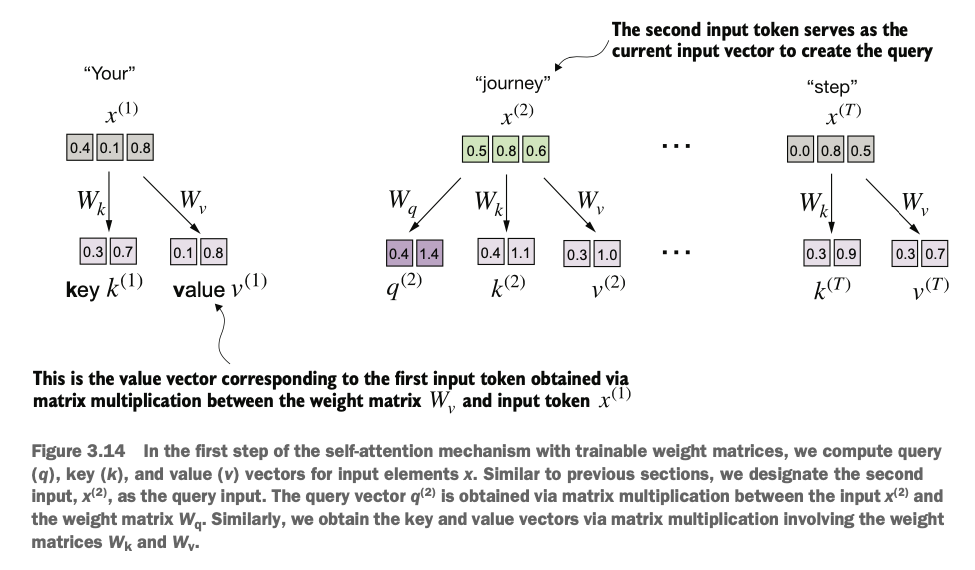

**Just like before, starting here by computing only one context vector, $z^{(2)}$, for illustration purposes.**

#### defining variables


In [17]:
x_2 = inputs[1] # the second input element
d_in = inputs.shape[1] # input embedding size
d_out = 2 # output embedding size

print(f'''{x_2}, x_2 shape: {x_2.shape}
{d_in}, {d_out}''')

tensor([0.5500, 0.8700, 0.6600]), x_2 shape: torch.Size([3])
3, 2


### Step 1: Initializing three weight matrices: $W_q$ , $W_k$ , and $W_v$ & Computing Query, Key, Value Vectors

In [18]:
torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

print(f'W_query: {W_query}\n\nW_key: {W_key}\n\nW_value: {W_value}')

W_query: Parameter containing:
tensor([[0.2961, 0.5166],
        [0.2517, 0.6886],
        [0.0740, 0.8665]])

W_key: Parameter containing:
tensor([[0.1366, 0.1025],
        [0.1841, 0.7264],
        [0.3153, 0.6871]])

W_value: Parameter containing:
tensor([[0.0756, 0.1966],
        [0.3164, 0.4017],
        [0.1186, 0.8274]])


In [19]:
# computing query, key, value vectors for x_2

query_2 = x_2 @ W_query
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value
print(query_2, key_2, value_2)

tensor([0.4306, 1.4551]) tensor([0.4433, 1.1419]) tensor([0.3951, 1.0037])


>[!NOTE]
>In the weight matrices W, the term “weight” is short for “weight parameters,” the values of a neural network that are optimized during training. This is not to be confused with the attention weights. As we already saw, attention weights determine the extent to which a context vector depends on the different parts of the input (i.e., to what extent the network focuses on different parts of the input).
In summary, weight parameters are the fundamental, learned coefficients that define the network’s connections, while attention weights are dynamic, context-specific values.

**Even though te temporary goal here is only to compute the one context vector, $z^{(2)}$, I'm still required to calculate the key and value vectors for all input elements as they are involved in computing the attention weights with respect to the query $q^{(2)}$ (see figure 3.14 above).**

In [20]:
keys = inputs @ W_key
values = inputs @ W_value
print(f'''keys.shape: {keys.shape}
values.shape: {values.shape}''')

keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])


---
### Step 2: Computing the Attention Scores
as shown in the figure below
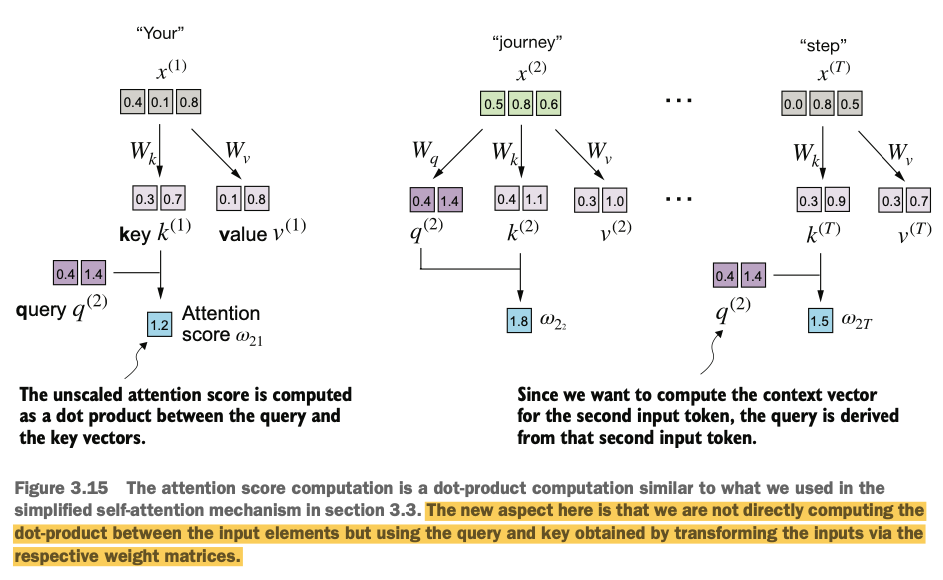

#### first, computing the attention score $w_{22}$, $w_{2...}$
(the one in the middle in the figure above)

In [21]:
keys_2 = keys[1] # remember, keys here have context since they are x_2 @ W_key
attn_score_22 = query_2.dot(keys_2)
attn_score_22

tensor(1.8524)

In [22]:
# can generalize this computation to all attention scores via matmul:

In [23]:
attn_scores_2 = query_2 @ keys.T
attn_scores_2

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])

---
### Step 3: Calculating the Attention Weights ($a_{21}$, $a_{22}$, $a_{2...}$, $a_{2T}$)
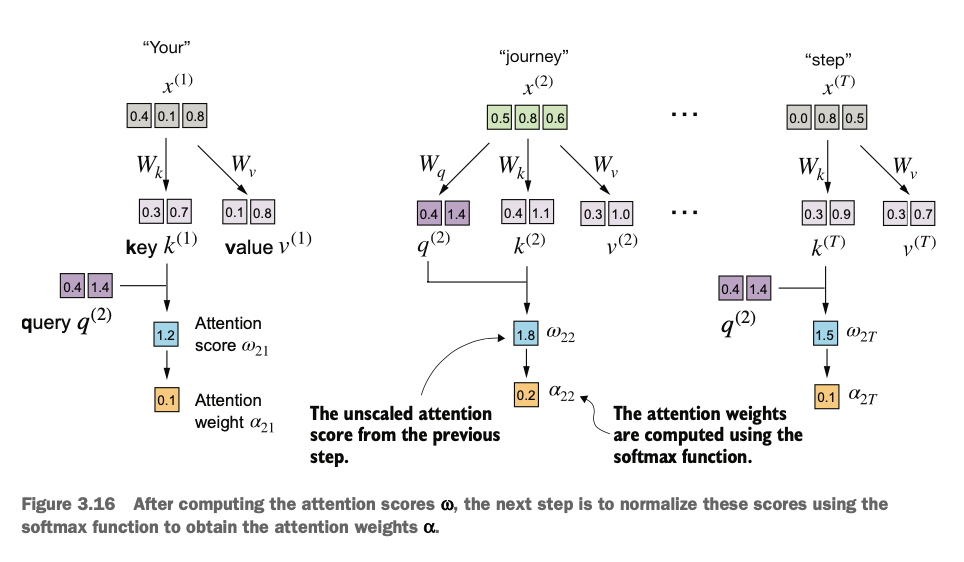

**Should compute the attention weights by scaling the attention scores and using the softmax function, just like before. However, now I have to scale the attention scores by dividing them by the square root of the embedding dimension ($d_k$) of the keys (taking the square root is mathematically the same as exponentiating by 0.5).**

In [24]:
d_k = keys.shape[-1]
d_k

2

In [25]:
attn_weights_2 = torch.softmax(attn_scores_2 / d_k**0.5, dim=-1)
attn_weights_2

tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])

#### ↑ Why are attention scores being normalized by the sqrt of the embedding dimension size?
From Raschka's book: The reason for the normalization by the embedding dimension size is **to improve the training performance by avoiding small gradients**.

For instance, when scaling up the embedding dimension, which is typically greater than 1,000 for GPT-like LLMs, large dot products can result in very small gradients during backpropagation due to the softmax function applied to them. As dot products increase, the softmax function behaves more like a step function, resulting in gradients nearing zero. These small gradients can drastically slow down learning or cause training to stagnate.

The scaling by the square root of the embedding dimension is the reason why this self-attention mechanism is also called scaled-dot product attention.

---
### Final Step: Computing the Context Vector ($z^{(2)}$)
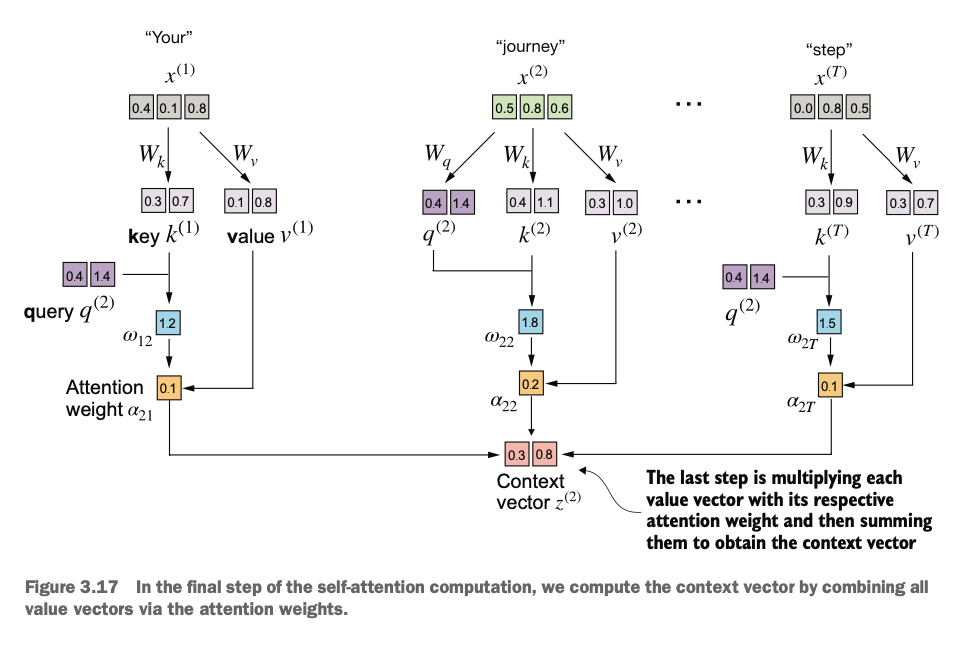

In [26]:
context_vec_2 = attn_weights_2 @ values
context_vec_2 # for x^2 ("journey")

tensor([0.3061, 0.8210])

---
---
## 3. Implementing a compact self-attention Python class

### 3.1 without using PyTorch's Linear Layers

In [27]:
import torch.nn as nn
class SelfAttention_v1(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        # let me add the rest on your own
        self.W_query = nn.Parameter(torch.rand(d_in, d_out))
        self.W_key = nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out))

    def forward(self, x):
        # to add on my: k, q, v, attnsco, attnw, contxv
        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value
        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        context_vec = attn_weights @ values
        return context_vec

In [28]:
torch.manual_seed(700)

inputs = torch.tensor(
    [[0.43, 0.15, 0.89], # Your     (x^1)
     [0.55, 0.87, 0.66], # journey  (x^2)
     [0.57, 0.85, 0.64], # starts (x^3)
     [0.22, 0.58, 0.33], # with (x^4)
     [0.77, 0.25, 0.10], # one (x^5)
     [0.05, 0.80, 0.55]] # step (x^6)
)

d_in = inputs.shape[-1]
d_out = 2

sa_v1 = SelfAttention_v1(d_in, d_out)

In [29]:
sa_v1(inputs)

tensor([[0.4746, 0.9078],
        [0.4889, 0.9333],
        [0.4883, 0.9321],
        [0.4761, 0.9095],
        [0.4675, 0.8937],
        [0.4836, 0.9235]], grad_fn=<MmBackward0>)

---
### 3.2 With using PyTorch's Linear Layers (recommended)

In [35]:
class SelfAttention_v2(nn.Module):
    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        queries = self.W_query(x)
        keys = self.W_key(x)
        values = self.W_value(x)
        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        context_vec = attn_weights @ values
        return context_vec

In [36]:
torch.manual_seed(789)

d_in = inputs.shape[-1]
d_out = 2

sa_v2 = SelfAttention_v2(d_in, d_out)

In [37]:
sa_v2(inputs)

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)

Btw: different output compared to sa_v1 because of different initial weights for the weight matrices.

---
---
Awesome. This ends the simplest version of the scaled dot-product attention implementation. I'll continue with the casual attention on the next notebook. 